### Imports

In [46]:
import zipfile
import os
from tqdm import tqdm

### Load Data

Unzip Data

In [47]:
with zipfile.ZipFile('all_alignments_trimmed.zip', 'r') as zip_ref:
    zip_ref.extractall('Data')

Find FASTA Files

In [48]:
path = './Data/all_alignments_trimmed'
fasta_files = [f for f in os.listdir(path) if f.endswith('.fasta')]
print(fasta_files)

['OG10015_Hmm10-gb.fasta', 'OG10028_Hmm10-gb.fasta', 'OG10087_Hmm10-gb.fasta', 'OG10092_Hmm10-gb.fasta', 'OG10107_Hmm10-gb.fasta', 'OG10131_Hmm10-gb.fasta', 'OG10137_Hmm10-gb.fasta', 'OG10170_Hmm10-gb.fasta', 'OG10206_Hmm10-gb.fasta', 'OG10212_Hmm10-gb.fasta', 'OG10257_Hmm10-gb.fasta', 'OG1026_Hmm10-gb.fasta', 'OG10299_Hmm10-gb.fasta', 'OG10316_Hmm10-gb.fasta', 'OG10325_Hmm10-gb.fasta', 'OG10383_Hmm10-gb.fasta', 'OG10448_Hmm10-gb.fasta', 'OG10449_Hmm10-gb.fasta', 'OG1044_Hmm10-gb.fasta', 'OG10461_Hmm10-gb.fasta', 'OG10511_Hmm10-gb.fasta', 'OG10538_Hmm10-gb.fasta', 'OG10553_Hmm10-gb.fasta', 'OG10561_Hmm10-gb.fasta', 'OG10565_Hmm10-gb.fasta', 'OG10585_Hmm10-gb.fasta', 'OG10619_Hmm10-gb.fasta', 'OG10632_Hmm10-gb.fasta', 'OG10648_Hmm10-gb.fasta', 'OG10672_Hmm10-gb.fasta', 'OG10702_Hmm10-gb.fasta', 'OG10710_Hmm10-gb.fasta', 'OG10769_Hmm10-gb.fasta', 'OG10792_Hmm10-gb.fasta', 'OG10795_Hmm10-gb.fasta', 'OG10803_Hmm10-gb.fasta', 'OG10826_Hmm10-gb.fasta', 'OG10830_Hmm10-gb.fasta', 'OG1085_Hmm10

Get Phyla

In [49]:
species_dict = {}

with open('species_group.txt', 'r') as file:
    lines = file.readlines()

    for line in lines:
        species, phylum = line.split('>')[0].strip(), line.split('>')[1].strip()
        species_dict[species.strip()] = phylum

Function to Get Sequences From FASTA File as Dict

In [50]:
species_counts = {}
gene_counts = {}

# returns a dictionary object with sequence names as keys and sequences as values
def get_sequences(fasta_file):
    with open(os.path.join(path, fasta_file), 'r') as file:
        sequences = {}
        current_seq_name = None
        current_sequence = []
        for line in file:
            line = line.strip()
            if line.startswith('>'):  # Start of a new sequence
                if current_seq_name:  # Save the previous sequence
                    sequences[current_seq_name] = ''.join(current_sequence)
                    species_counts[current_seq_name] = species_counts.get(current_seq_name, 0) + 1
                current_seq_name = line[1:]  # Save the sequence name (exclude '>')
                current_sequence = []  # Reset the sequence buffer
            else:
                current_sequence.append(line)  # Collect sequence data
        if current_seq_name:  # Save the last sequence in the file
            sequences[current_seq_name] = ''.join(current_sequence)
            # species_counts[current_seq_name] = species_counts.get(current_seq_name, 0) + 1
    gene_counts[fasta_file] = len(sequences)
    species_counts["TOTAL GENES"] = species_counts.get("TOTAL GENES", 0) + 1
    return sequences

Dictionary of Dictionaries Containing Sequences for Every Gene

In [51]:
gene_sequences = {}
for fasta_file in fasta_files:
    sequences = get_sequences(fasta_file)
    gene_name = fasta_file.split('_')[0]
    gene_sequences[gene_name] = sequences

Save the Unique Species and their Counts

In [52]:
with open('species_count.txt', 'w') as f:
    for species, count in sorted(species_counts.items(), key=lambda x: x[1], reverse=True):
        f.write(f'{species}\t{count}\n')

In [ ]:
# Gene sequences -> keys
needed_species = ["Xenoturbella bocki@211205", "Pediculus humanus@282015", "Leucosolenia complicata@292502"]

for _ in range(25 - len(needed_species)):
    species_counts = {}
    for gene_name, sequences in gene_sequences.items():
        skip_gene = False
        for species in needed_species:
            if species not in sequences.keys():
                skip_gene = True
                break
        if skip_gene:
            continue
        for count_species in sequences.keys():
            if count_species in needed_species:
                continue
            species_counts[count_species] = species_counts.get(count_species, 0) + 1
    sorted_list = sorted(species_counts.items(), key=lambda x: x[1], reverse=True)
    needed_species.append(sorted_list[0][0])

print(needed_species)
num_genes = 0
genes_to_delete = []
for gene_name, sequences in gene_sequences.items():
    skip_gene = False
    relevant_count = 0
    species_to_delete = []
    for species in sequences.keys():
        if species in needed_species:
            relevant_count += 1
        else:
            species_to_delete.append(species)
    for species in species_to_delete:
        del sequences[species]
    if relevant_count != len(needed_species):
        genes_to_delete.append(gene_name)
        continue
    num_genes += 1
print(num_genes)

for gene_name in genes_to_delete:
    del gene_sequences[gene_name]

with open('included_species.txt', 'w') as f:
    for species in needed_species:
        f.write(f'{species} >{species_dict[species]}\n')



['Xenoturbella bocki@211205', 'Pediculus humanus@282015', 'Leucosolenia complicata@292502', 'Homo sapiens@338256', 'Balanoglossus cf._aurantica_JTC2014@323706', 'Saccoglossus kowalevskii@331685', 'Strongylocentrotus purpuratus@313517', 'Patiria miniata@327719', 'Asterias forbesi@321609', 'Sclerodactyla briareus@321628', 'Stichopus japonicus@291573', 'Oxycomanthus japonicus@313265', 'Echinarachnius parma@296875', 'Harrimaniidae sp._n._clade_1_JTC2014@284051', 'Paratomella rubra@308417', 'Isodiametra pulchra@306835', 'Hofstenia miamia@291452', 'Loligo pealei@317280', 'Branchiostoma floridae@306508', 'Stomolophus meleagris@295611', 'Ptychodera bahamensis@271470', 'Ophiocoma echinata@285659', 'Symsagittifera roscoffensis@284582', 'Lottia gigantea@319634', 'Acropora cervicornis@299639']
290


### Calculate Distance Matrix

In [58]:
blosum = {}
with open('blosum62.txt', 'r') as f:
    lines = f.readlines()[6:]
    keys = lines[0].split()
    keys[-1] = '-'
    for i, line in enumerate(lines[1:]):
        blosum[keys[i]] = {k : int(v) for (k,v) in zip(keys, line.split()[1:])}

def calculate_distance(seq1, seq2):
    score = 0
    for i in range(len(seq1)):
        a = '-' if seq1[i] == '?' else seq1[i]
        b = '-' if seq2[i] == '?' else seq2[i]
        score -= blosum[a][b]
    return score

In [59]:
def get_distance_matrix(sequences):
    distance_matrix = {}
    for seq1_name, seq1 in sequences.items():
        distance_matrix[seq1_name] = {}
        for seq2_name, seq2 in sequences.items():
            distance_matrix[seq1_name][seq2_name] = calculate_distance(seq1, seq2)
    return distance_matrix

In [60]:
distance_matrices = {}
for gene_name, sequences in tqdm(gene_sequences.items()):
    distance_matrices[gene_name] = get_distance_matrix(sequences)

100%|██████████| 290/290 [00:15<00:00, 18.89it/s]


### Perform Neighbor Joining

In [61]:
import copy
def min_S_value(D, u):
    m = len(D)
    min_S, min_i, min_j = float("inf"), -1, -1
    for k in D:
        for l in D[k]:
            if l != k:
                crit = (m - 2) * D[k][l] - u[k] - u[l]
                if crit < min_S:
                    min_S = crit
                    min_i = k
                    min_j = l
    return (min_i, min_j)

def neighbor_join(D):
    D = copy.deepcopy(D)
    T = {} 
    clusters = []  # List of clusters
    r = len(D)
    new_node = r
    species = set(D.keys())

    # Initialize clusters from D
    current_clusters = {k: [k] for k in D}

    while len(D) > 2:
        u = {k: sum(D[k].values()) for k in D}
        i, j = min_S_value(D, u)

        r = new_node
        new_node += 1

        if i not in T:
            T[i] = {}
        if j not in T:
            T[j] = {}
        T[r] = {}
        T[r][i] = 0.5 * (D[i][j] + (u[i] - u[j]) / (len(D) - 2))
        T[i][r] = T[r][i]
        T[r][j] = 0.5 * (D[i][j] + (u[j] - u[i]) / (len(D) - 2))
        T[j][r] = T[r][j]

        # Update clusters: combine the clusters of i and j
        current_clusters[r] = current_clusters[i] + current_clusters[j]
        clusters.append(current_clusters[r])  # Add the new cluster to the list

        new_dist = {}
        for m in D:
            if m != i and m != j:
                new_dist[m] = 0.5 * (D[i][m] + D[j][m] - D[i][j])  
                D[m][r] = new_dist[m]

        D[r] = new_dist

        del D[i]
        del D[j]
        for k in D:
            if i in D[k]:
                del D[k][i]
            if j in D[k]:
                del D[k][j]

        del current_clusters[i]
        del current_clusters[j]

    extra = list(D.keys())
    i, j = extra[0], extra[1]
    if i not in T:
        T[i] = {}
    if j not in T:
        T[j] = {}
    T[i][j] = D[i][j]
    T[j][i] = D[i][j]

    # Add the final cluster
    clusters.append(current_clusters[i] + current_clusters[j])

    #change to cluster to set for returning
    ret = []
    for cluster in clusters:
        ret.append(set(cluster))
        ret = sorted(ret, key=len) #sort by length

    return T, ret,species

In [62]:
trees = {}
genes = list(gene_sequences.keys())
for gene in genes:
    trees[gene] = neighbor_join(distance_matrices[gene])        

Creating a way to get species phyla from name

In [63]:
trees_by_phyla = {}
for gene in genes:
    new_clusters = []
    for cluster in trees[gene][1]:
        phyla = set()
        for species in cluster:
            phyla.add(species_dict[species])
        new_clusters.append(phyla)
    trees_by_phyla[gene] = new_clusters


#print clusters for one gene w/ normal names and phyla      
print(trees[genes[0]][1])
print(trees_by_phyla[genes[0]])      


[{'Xenoturbella bocki@211205', 'Sclerodactyla briareus@321628'}, {'Loligo pealei@317280', 'Ophiocoma echinata@285659'}, {'Isodiametra pulchra@306835', 'Symsagittifera roscoffensis@284582'}, {'Echinarachnius parma@296875', 'Strongylocentrotus purpuratus@313517'}, {'Saccoglossus kowalevskii@331685', 'Harrimaniidae sp._n._clade_1_JTC2014@284051'}, {'Isodiametra pulchra@306835', 'Hofstenia miamia@291452', 'Symsagittifera roscoffensis@284582'}, {'Xenoturbella bocki@211205', 'Sclerodactyla briareus@321628', 'Loligo pealei@317280', 'Ophiocoma echinata@285659'}, {'Isodiametra pulchra@306835', 'Hofstenia miamia@291452', 'Paratomella rubra@308417', 'Symsagittifera roscoffensis@284582'}, {'Isodiametra pulchra@306835', 'Ophiocoma echinata@285659', 'Symsagittifera roscoffensis@284582', 'Xenoturbella bocki@211205', 'Sclerodactyla briareus@321628', 'Loligo pealei@317280', 'Hofstenia miamia@291452', 'Paratomella rubra@308417'}, {'Isodiametra pulchra@306835', 'Ophiocoma echinata@285659', 'Leucosolenia 

counting clusters

In [64]:
cluster_counts = {}
for gene in genes:
    clusters = trees[gene][1]
    for c in clusters:
        c = tuple(list(c))
        if c in cluster_counts.keys():
            cluster_counts[c] += 1
        else:
            cluster_counts[c] = 1

In [65]:
l = list(cluster_counts.values())
l.sort(reverse=True)
print(l)

filt = []
filt_phyla = []
for tup in cluster_counts.keys():
    if cluster_counts[tup] > 100:
        filt.append(tup)
        phyla = set()
        for species in tup:
            phyla.add(species_dict[species])
        filt_phyla.append(phyla)

print(filt)
print(filt_phyla)


[221, 135, 119, 113, 103, 99, 72, 72, 59, 53, 50, 48, 43, 41, 33, 30, 27, 23, 22, 22, 21, 21, 18, 17, 17, 16, 16, 16, 15, 15, 14, 14, 14, 13, 13, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

### Visualize Tree

### Trying Linkage Clustering

In [66]:
import copy
import nose.tools as nt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from scipy.stats import norm
from scipy.cluster import hierarchy



In [67]:
def cluster(distances):
    distances = copy.deepcopy(distances)
    clusters = set(distances.keys())
    n = len(clusters)
    cluster2idx = { cell : idx for idx, cell in enumerate(clusters) }
    idx2cluster = [ cell for cell in clusters ]
    Z = np.empty((0, 4), float)
    membership = [ set([cluster2idx[cell]]) for cell in clusters ]

    while len(clusters) > 1:
        dist, c1, c2 = None, None, None
        m = float('inf')
        for cell_1 in clusters:
          for cell_2 in clusters:
            if cell_1 != cell_2:
              if (distances[cell_1][cell_2] < m or (distances[cell_1][cell_2] == m and (cell_1, cell_2) < (c1, c2))):
                m = distances[cell_1][cell_2]
                dist = m
                c1 = cell_1
                c2 = cell_2

        idx_c1 = cluster2idx[c1]
        idx_c2 = cluster2idx[c2]
        new_cluster = str(n + len(Z))
        new_cluster_idx = len(idx2cluster)

        membership.append( membership[idx_c1] | membership[idx_c2])
        Z = np.append(Z,
                      np.array([[cluster2idx[c1], cluster2idx[c2], dist, len(membership[new_cluster_idx])]]),
                      axis=0)

        distances[new_cluster] = {}

        for cell in clusters:
          if cell != c1 and cell != c2:
            distances[new_cluster][cell] = min(distances[c1][cell], distances[c2][cell])
            distances[cell][new_cluster] = distances[new_cluster][cell]
            del distances[cell][c1]
            del distances[cell][c2]
        del distances[c1]
        del distances[c2]


        clusters.add(new_cluster)
        cluster2idx[new_cluster] = len(idx2cluster)
        idx2cluster.append(new_cluster)

        clusters.remove(c1)
        clusters.remove(c2)
    return Z, idx2cluster[:n]

In [68]:
trees = {}
genes = list(gene_sequences.keys())
for gene in genes:
    trees[gene] = cluster(distance_matrices[gene])     

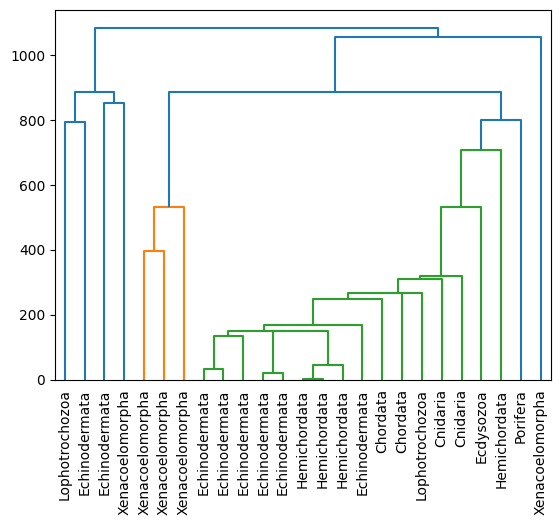

In [69]:
Z, labels = trees[genes[0]]
Z[:,2] = Z[:,2] - min(Z[:,2]) + 1
lab_phyla = []
for i in range(len(labels)):
    lab_phyla.append(species_dict[labels[i]])
plt.figure()
dn = hierarchy.dendrogram(Z, labels=lab_phyla, leaf_rotation=90)
plt.show()


In [70]:
from scipy.cluster import hierarchy
def getNewick(node, newick, parentdist, leaf_names):
    if node.is_leaf():
        return "%s:%.2f%s" % (leaf_names[node.id], parentdist - node.dist, newick)
    else:
        if len(newick) > 0:
            newick = "):%.2f%s" % (parentdist - node.dist, newick)
        else:
            newick = ");"
        newick = getNewick(node.get_left(), newick, node.dist, leaf_names)
        newick = getNewick(node.get_right(), ",%s" % (newick), node.dist, leaf_names)
        newick = "(%s" % (newick)
        return newick

Newick = {}
for gene in genes:
      Z, labels = trees[gene]
      Z[:,2] = Z[:,2] - min(Z[:,2]) + 1
      tree = hierarchy.to_tree(Z,False)
      newi = getNewick(tree, "", tree.dist, labels)
      Newick[gene] = newi